<a href="https://colab.research.google.com/github/yumeniown/Software-Engineering-IT-Leaders-of-the-Future/blob/main/%D0%A0%D0%B5%D0%BA%D1%83%D1%80%D1%80%D0%B5%D0%BD%D1%82%D0%BD%D1%8B%D0%B5_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D1%8B%D0%B5_%D1%81%D0%B5%D1%82%D0%B8_2_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Методы валидации данных. Оптимизация гиперпараметров модели.

**Основная цель обучения модели** — получить модель с хорошей прогностической способностью, которая решает поставленную задачу с заданным показателем метрики.

Нам не столько важен результат предсказания на том наборе данных, на котором мы обучаем модель (нам уже известны все значения признаков в нём), сколько важно уметь предсказывать значения целевого признака для объектов, которых мы ещё не видели.

> Таким образом, главная цель машинного обучения — усвоить общие закономерности в данных, а не просто запомнить обучающий, или тренировочный, набор данных (training data).

Поэтому так важно иметь отложенный набор данных (с известными правильными ответами), который модель не видела во время обучения. На нём мы будем оценивать качество обученной модели.

Ранее, тот набор данных, на котором мы проверяли качество построенной модели, мы называли тестовым набором данных (testing data). Мы заранее выделяли этот набор данных для того, чтобы рассчитать финальную метрику модели и сделать вывод о том, устраивает ли нас качество моделирования. Такой подход называется двухкомпонентным.

Мы использовали тестовый набор не только для проверки итогового качества, но и для подбора внешних параметров. Вспомните: мы выбирали оптимальные пороги вероятности и коэффициенты регуляризации, при которых наблюдался максимум целевой метрики (мы использовали f-меру).

> Однако такой подход не совсем корректен, ведь мы подстраивали модель под тестовую выборку, то есть по сути занимались небольшим самообманом. Тестовая выборка должна быть «независимым судьёй», который объективно и непредвзято «выносит приговор» нашей модели.

Из-за этого в больших Data Science-проектах используются не два, а три набора данных: в дополнение к тренировочному и тестовому наборам данных выделяется **валидационный набор (validation data)**. Этот набор используется для промежуточного контроля качества модели и настройки внешних параметров, которые задаёт исследователь при построении модели. Такой подход называется трёхкомпонентным.

Итак, существуют три основных вида выборок, которые используются в машинном обучении:

* **Обучающая** (тренировочная) — набор данных, который используется в процессе обучения модели (подбора внутренних параметров, например коэффициентов линейной регрессии или предикатов в деревьях решений).

* **Валидационная** (проверочная) — набор данных, на котором мы оцениваем промежуточные результаты обучения. Основная цель создания такого набора данных — отслеживание переобучения.
На валидационной выборке мы производим подбор гиперпараметров — внешних параметров модели, например коэффициентов регуляризации, максимальной глубины дерева, количества деревьев в случайном лесу и т. д.

* **Тестовая** (контрольная) — набор данных, который имитирует работу модели в реальных условиях после подбора всех параметров. С помощью этого набора осуществляется окончательная проверка качества. Главное условие для тестовой выборки — она должна быть независимой от обучающей.

В промышленности, научных кругах и различной литературе термины **валидационная** и **тестовая** выборка зачастую употребляются как синонимы. Строго говоря, они не являются таковыми.

Тестирование — это попытка что-то выяснить, а валидация — доказать, что что-то является истиной (в нашем случае — доказать, что качество модели на валидационной выборке совпадает с качеством при обучении).

Вне зависимости от того, как будут называться контрольные выборки, важная концепция, которую необходимо сохранить, состоит в том, что окончательный набор (называемый тестом или валидацией) не используется в процессе обучения модели, а используется исключительно для оценки её качества.

Мы будем решать задачу классификации: классифицировать воду на пригодную и непригодную для питья на основе её химического состава.

In [ ]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import metrics #метрики
from sklearn import model_selection #методы разделения и валидации
from sklearn import linear_model #линейные модели
from sklearn import tree #деревья решений
plt.style.use('seaborn-v0_8') #стиль отрисовки seaborn
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
water_data = pd.read_csv('drive/MyDrive/water_potability.csv')
water_data.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


видно, что большинство столбцов таблицы являются числовыми. Целевой признак — Potability (пригодность для питья): 1 — вода пригодна, 0 — вода непригодна для питья.

В данных есть пропуски. Выведем информацию о них в процентном соотношении:

In [ ]:
water_data.isnull().mean() * 100

,0
ph,14.987790
Hardness,0.000000
Solids,0.000000
Chloramines,0.000000
Sulfate,23.840049
Conductivity,0.000000
Organic_carbon,0.000000
Trihalomethanes,4.945055
Turbidity,0.000000
Potability,0.000000


Итак, у нас отсутствует около 15 % информации о кислотности воды (ph), около 24 % — о содержании сульфатов (Sulfate) и около 5 % — о тригалометанах (Trihalomethanes). Мы знаем, что пропуски — непосильная ноша для большинства моделей машинного обучения. Их необходимо обработать.

Заполним пропуски медианным значением в признаке зависимости класса воды (Potability). Для этого сгруппируем данные по признаку Potability, посчитаем медиану в каждой группе, а затем отправим результат в метод fillna():

In [ ]:
water_data.groupby('Potability')['ph'].transform('median')

,ph
0,7.035456
1,7.035456
2,7.035456
3,7.035456
4,7.035456
...,...
3271,7.036752
3272,7.036752
3273,7.036752
3274,7.036752


In [ ]:
#Заполняем пропуски
water_data['ph'] = water_data['ph'].fillna(water_data.groupby('Potability')['ph'].transform('median'))
water_data['Sulfate'] = water_data['Sulfate'].fillna(water_data.groupby('Potability')['Sulfate'].transform('median'))
water_data['Trihalomethanes'] = water_data['Trihalomethanes'].fillna(water_data.groupby('Potability')['Trihalomethanes'].transform('median'))

In [ ]:
water_data.isnull().mean() * 100

,0
ph,0.0
Hardness,0.0
Solids,0.0
Chloramines,0.0
Sulfate,0.0
Conductivity,0.0
Organic_carbon,0.0
Trihalomethanes,0.0
Turbidity,0.0
Potability,0.0


In [ ]:
X = water_data.drop('Potability', axis=1)
y = water_data['Potability']

##### Вопросы:

1. Зачем нужно разделение на валидационную и тестовую выборки?
2. Когда выборка делится на несколько частей, какая часть обычно самая большая?

##### Ответы:

1. Когда производится подбор внешних параметров, модель может неявно адаптироваться под валидационную выборку, поэтому следует дополнительно проверить её качество на тестовой.
2. Обучающая

#### HOLD-OUT

**Метод hold-out** (отложенная выборка) нам уже знаком. Это самый простой и очень популярный метод.

Его идея состоит в том, что для проверки модели мы просто случайным образом разбиваем весь набор данных на обучающую, валидационную и тестовую выборки (последняя — по желанию).

> Обычно разбиение производится в соотношении 70/30 или 80/20 при двухкомпонентном подходе, и в соотношении 70/15/15 или 80/10/10 — при трёхкомпонентном.

Схема разбиения представлена ниже:

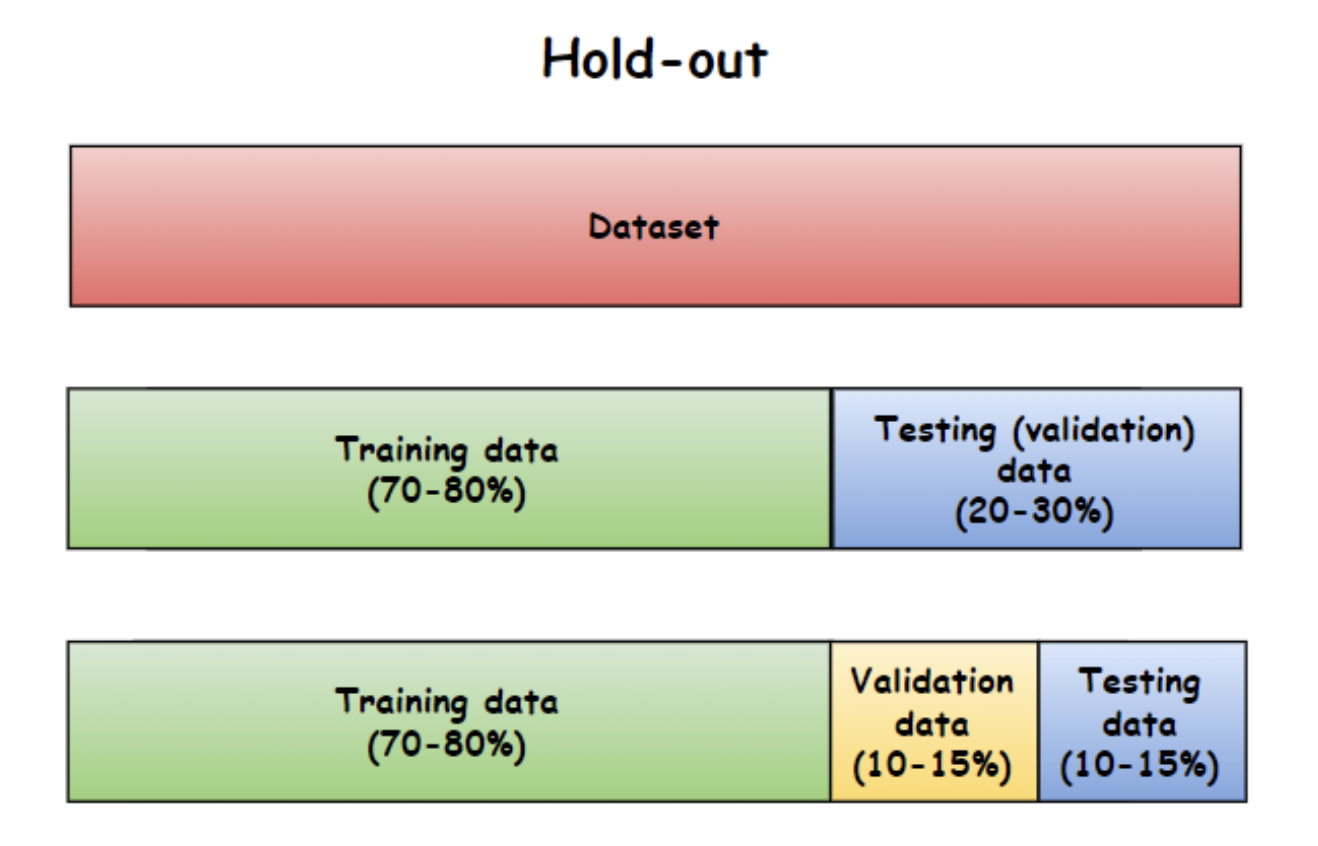

Плюсы:
* Очень простой и понятный.
* Чаще всего применяется на больших датасетах, так как требует значительно меньше вычислительных мощностей, чем другие методы.


Минусы:
* Важно помнить, что разбиение производится случайным образом и оценка в этом методе зависит от того, какие наблюдения попали в набор для валидации. Это плохо, так как возможна ситуация, когда распределение целевого признака в тренировочной, валидационной (и тестовой) выборках может значительно различаться, и оценка качества может быть необъективной.

Все методы разбиения выборки и валидации, которые мы будем изучать, находятся в модуле model_selection.
Метод hold-out реализован в train_test_split(). Она предназначена для разбиения исходного набора данных случайным образом на две части в заданных соотношениях.

Основные параметры train_test_split():

- *arrays — порядковый аргумент с переменным количеством. Набор массивов (это могут быть списки, numpy-массивы, DataFrame), которые подлежат разбиению.
- test_size — размер тестовой (валидационной) выборки. Может быть указан в долях. Если параметр train_size задан дробным числом с плавающей точкой, то параметр test_size определяется автоматически как 1-train_size.
- train_size — размер тренировочной выборки. Может быть указан в долях. Если параметр test_size задан дробным числом с плавающей точкой, то параметр train_size определяется автоматически как 1-test_size.
random_state — число, на основе которого производится генерация случайных чисел.
- shuffle — параметр, указывающий, стоит ли перемешивать выборку перед разбиением (по умолчанию True).
stratify — стратифицированное разбиение.

Если мы используем двухкомпонентный подход (разбиваем выборку на тренировочную и валидационную, она же тестовая), то всё очень просто: нам лишь нужно вызвать функцию train_test_split() и передать в неё матрицу наблюдений X и вектор-столбец с правильными ответами y.

In [ ]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_valid.shape))

Train shape: (2620, 9)
Test shape: (656, 9)


В качестве модели будем использовать дерево решений с максимальной глубиной 7, энтропией в качестве критерия информативности, минимальное число объектов в листе дерева — 5.

После обучения сделаем предсказание для каждой из выборок и рассчитаем метрику. В качестве метрики для простоты возьмём долю правильных ответов — accuracy.

In [ ]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел
)
#Обучаем модель на тренировочной выборке
model.fit(X_train, y_train)

#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)

#Выводим значения метрик
print('Train hold-out accuracy: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Valid hold-out accuracy: {:.2f}'.format(metrics.accuracy_score(y_valid, y_valid_pred)))

Train hold-out accuracy: 0.82
Valid hold-out accuracy: 0.77


Если же мы используем трёхкомпонентный подход (разбиваем выборку на тренировочную, валидационную и отдельную тестовую), нам понадобится чуть больше кода. К сожалению, в sklearn нет специализированного функционала для такого разбиения.

Применим функцию train_test_split() дважды: сначала разобьём исходный набор на тренировочный и валидационный в соотношении 80/20, затем разобьём валидационный набор на валидационный и тестовый в соотношении 50/50. В итоге наша выборка будет разбита в соотношении 80/10/10:

In [ ]:
#разбиваем исходную выборку на тренировочную и валидационную в соотношении 80/20
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)
#разбиваем валидационную выборку на валидационную и тестовую в соотношении 50/50
X_valid, X_test, y_valid, y_test = model_selection.train_test_split(X_valid, y_valid, test_size=0.5, random_state=42)

print('Train shape: {}'.format(X_train.shape))
print('Valid shape: {}'.format(X_valid.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (2620, 9)
Valid shape: (328, 9)
Test shape: (328, 9)


В этом случае мы будем обучаться на 2620 примерах, 328 будем использовать для промежуточного контроля и подбора внешних параметров и ещё 328 будут нашим контрольным рубежом — их мы будем использовать для принятия финального решения о качестве модели.

#### K-FOLD

Метод k-fold более известен как кросс-валидация (cross validation), или перекрёстный контроль.

Пожалуй, это самый популярный метод валидации для оценки качества моделирования, и он используется практически во всех проектах. Эта идея также применяется во многих моделях и методах машинного обучения, например в стекинге.

**Алгоритм кросс-валидации:**

1. Разбить исходную выборку на k частей — фолдов (fold).
2. Повторять k раз:
    - Обучить модель на k-1 частях. Назовём их тренировочными фолдами (training fold).
    - Произвести оценку качества (вычислить метрику) на оставшейся части. Назовем её валидационным фолдом (validation fold).
3. Усреднить значения метрики на валидационных фолдах.

На рисунке ниже представлена схема работы кросс-валидации с предварительно выделенной для тестирования выборкой, то есть первоначально весь датасет разделяется на тренировочную и тестовую (отложенную) выборки. Тестовые данные (testing data) используются только для финального контроля качества и сравнения моделей между собой. Тренировочные данные (training data) используются для кросс-валидации, разделяясь при каждой итерации на тренировочные и валидационные фолды (training fold и validation fold):

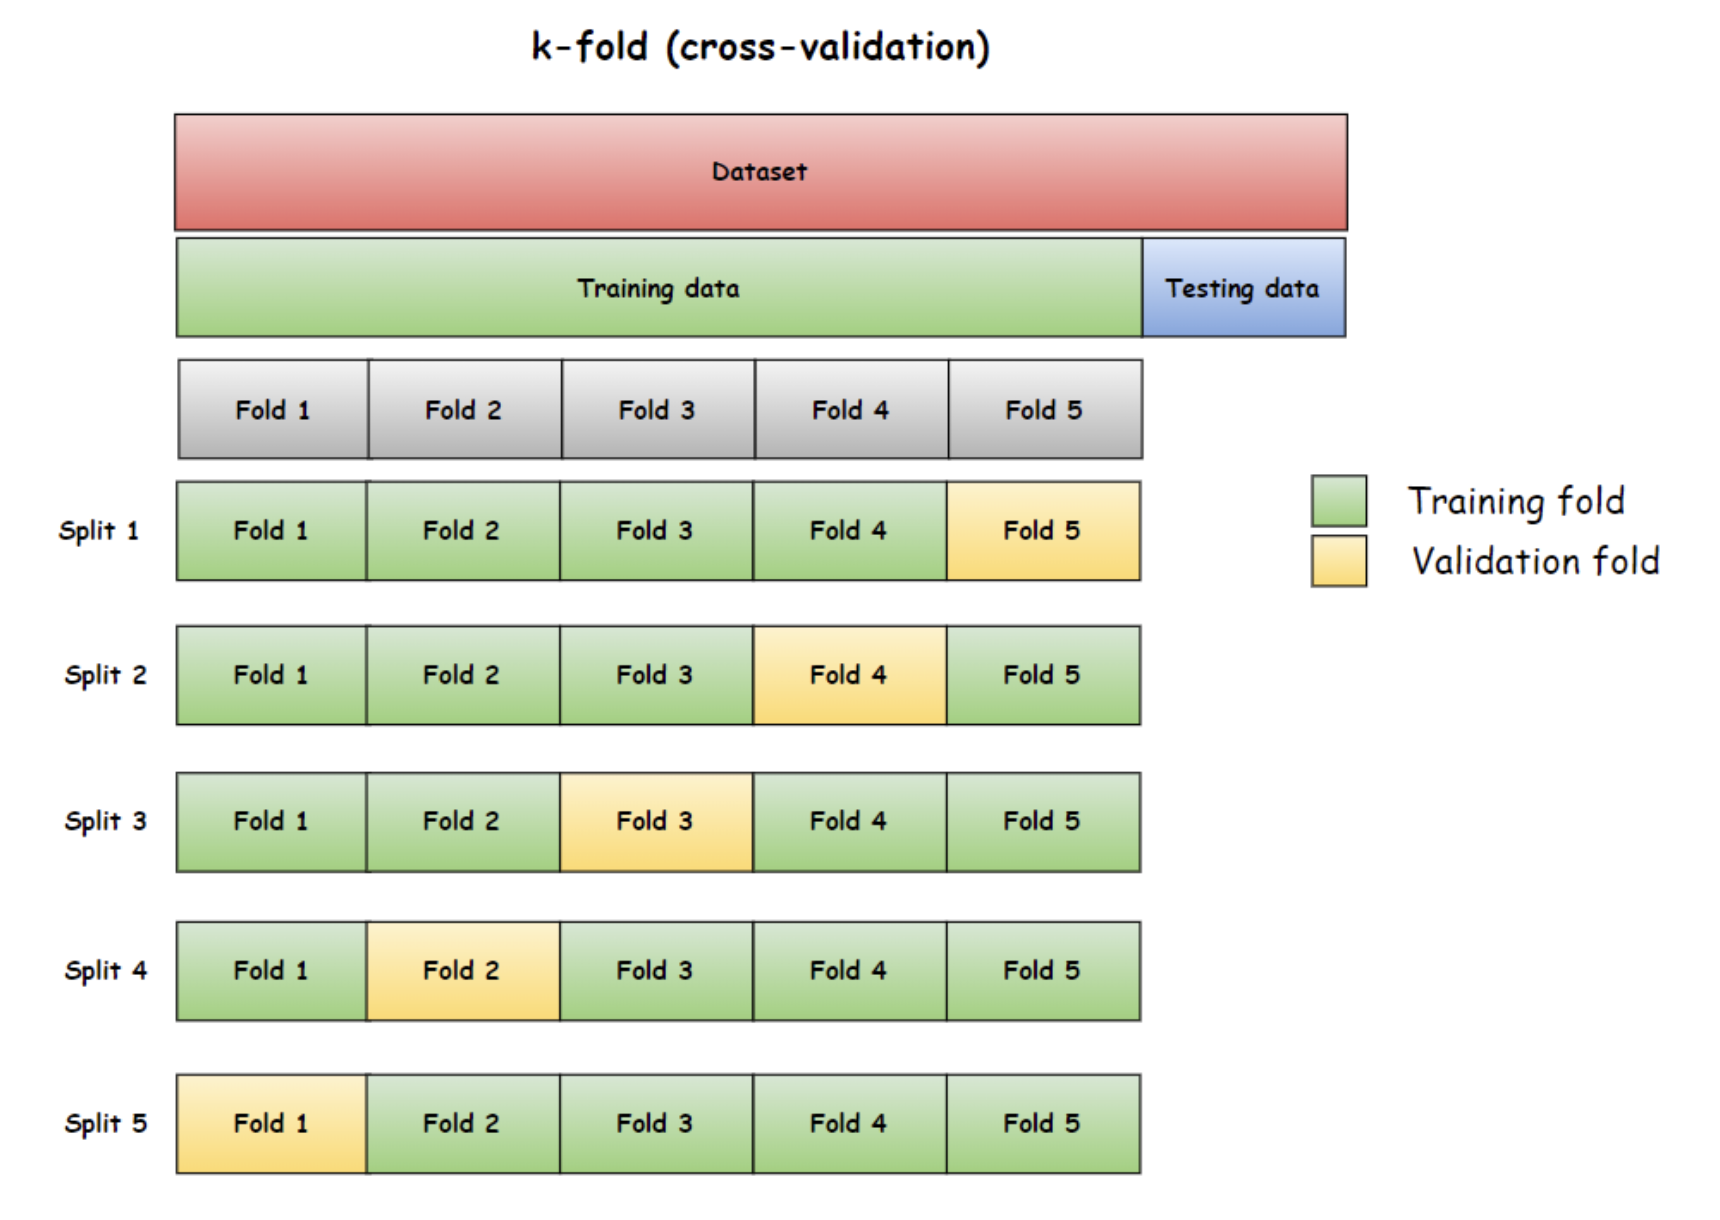

Благодаря такому подходу мы избавляемся от необходимости создавать отложенную валидационную выборку — мы генерируем её искусственно на каждом из этапов кросс-валидации из исходного набора данных. Каждая из k частей исходного обучающего набора данных используется в качестве валидационной выборки.

Для больших наборов данных в качестве значения k часто берут 10, то есть выборка разбивается на десять фолдов. В случае маленьких выборок k берут равным 3 или 5.

> Чем больше k, тем больше моделей будут обучаться, тем объективнее будет оценка качества, однако тем больше времени займёт процесс валидации.

Плюсы:
- Подход позволяет получить более устойчивую к выбросам оценку качества модели, так как модель обучается на нескольких независимых наборах данных.

- Значения метрик получаются более объективными, ведь мы обучаем одну модель k  раз — у нас получается  независимых друг от друга значений метрики.

> Мы оцениваем метрику не по одному значению на валидационной выборке, как это было в hold-out, а по k значений. Если k достаточно велико, можно даже построить гистограмму и оценить, в каких пределах находится истинное качество. Однако на практике этим занимаются крайне редко, так как такие вычисления очень времязатратны.


Минусы:
- Подход предусматривает, что мы обучаем одну и ту же модель k раз, что, очевидно, плохо сказывается на производительности. Если модель обучается довольно медленно (например, сложная нейронная сеть), то валидация может занять очень много времени.

В библиотеке sklearn метод k-fold реализован в классе KFold.

Основные параметры инициализатора KFold:

- n_split — число фолдов (число k из метода k-fold). По умолчанию — 5.
- shuffle — параметр, указывающий, стоит ли перемешивать исходный набор данных перед разбиением. По умолчанию — False.


> У объекта класса KFold есть метод split(). В данный метод необходимо передать матрицу наблюдений X и вектор-столбец ответов y — метод вернёт генератор, который позволит получать индексы тренировочной и валидационной выборок, сгенерированных по методу k-fold.

Будем использовать двухкомпонентный контроль, то есть подавать в кросс-валидацию весь доступный набор данных без предварительного выделения тестовой выборки.

Создадим объект KFold для кросс-валидации с пятью фолдами, остальные параметры оставим по умолчанию. Затем организуем цикл for для получения элементов из генератора, созданного с помощью метода split(). На каждой итерации в переменных train_index и valid_index будут находиться индексы текущей тренировочной и валидационной выборок соответственно.

В цикле будем:

- выделять строки таблицы, относящиеся к текущим тренировочной и валидационной выборкам, в отдельные таблицы;
- обучать дерево решений;
- делать предсказания для текущих тренировочной и валидационной выборок;
- рассчитывать метрику accuracy на текущих выборках и заносить её значение в список.

In [ ]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел
)

#Создаём объект кросс-валидатора KFold
kf = model_selection.KFold(n_splits=5)
#Создаём список для хранения тренировочных и валидационных метрик
train_metrics = []
val_metrics = []

#Организуем цикл для кросс-валидации (используем весь набор данных)
#train_index — индексы тренировочной выборки
#valid_index — индексы валидационной выборки
for train_index, valid_index in kf.split(X, y):
    #Создаём тренировочную и валидационную выборку, обращаясь по текущим индексам
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_valid, y_valid = X.iloc[valid_index], y.iloc[valid_index]

    #Обучаем дерево решений на тренировочной выборке
    model.fit(X_train, y_train)

    #Делаем предсказание для каждой из выборок
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)

    #Рассчитываем метрику и заносим её в список
    train_metrics.append(metrics.accuracy_score(y_train, y_train_pred))
    val_metrics.append(metrics.accuracy_score(y_valid, y_valid_pred))

In [ ]:
print(train_metrics)
print(val_metrics)

# В каждом из выведенных списков содержится по пять значений метрики accuracy, вычисленных на тренировочном
#  и валидационном фолдах кросс-валидации. Для агрегированной оценки рассчитаем среднее значение метрик:

print('Train k-fold mean accuracy: {:.2f}'.format(np.mean(train_metrics)))
print('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(val_metrics)))

[0.8034351145038168, 0.8168637924456315, 0.8027470431133156, 0.8267836703548264, 0.8157191911484166]
[0.7957317073170732, 0.7053435114503817, 0.7358778625954199, 0.7282442748091603, 0.732824427480916]
Train k-fold mean accuracy: 0.81
Valid k-fold mean accuracy: 0.74


Итак, среднее значение метрики accuracy на кросс-валидации равно 0.81 для тренировочных фолдов и 0.74 — для валидационных фолдов. Помним о том, что основной показатель для нас — метрика на валидационных фолдах (если не предусмотрена тестовая выборка).

> На самом деле весь приведённый выше код можно значительно сократить, если использовать специальную функцию для кросс-валидации — cross_validate() из модуля model_selection. Она организует процедуру кросс-валидации и расчёт метрик.



Основные параметры функции cross_validate():

* estimator — модель, качество которой будет проверяться на кросс-валидации.
* X — матрица наблюдений.

* y — вектор-столбец правильных ответов.
* cv — кросс-валидатор из библиотеки sklearn (например, KFold) или количество фолдов, на которые необходимо разбить выборку. По умолчанию используется кросс-валидация на пяти фолдах.
* scoring — название метрики в виде строки либо функция для её вычисления ('accuracy', 'precision', 'recall', 'f1' и другие; полный список — в документации к функции).
* return_train_score — параметр, указывающий стоит ли возвращать значения метрики, полученные на тренировочных фолдах. По умолчанию — False, то есть метрики считаются только на валидационных фолдах.

Функция возвращает словарь со следующими ключами:

* fit_time — время обучения модели на каждой итерации кросс-валидации;

* score_time — время вычисления метрик на каждой итерации кросс-валидации;
* test_score — значения метрик на валидационных фолдах;
* train_score — значения метрик на тренировочных фолдах.

In [ ]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел
)

#Создаём объект кросс-валидатора KFold
kf = model_selection.KFold(n_splits=5)

#Считаем метрики на кросс-валидации k-fold
cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X, #матрица наблюдений X
    y=y, #вектор ответов y
    cv=kf, #кросс-валидатор
    scoring='accuracy', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)

print(cv_metrics)

В массивах, хранящихся по ключам train_score и test_score, содержится по пять значений метрики accuracy, полученных на тренировочных и валидационных фолдах соответственно на каждой итерации кросс-валидации. Давайте рассчитаем среднее и сравним его с результатом, полученным ранее:

In [ ]:
print('Train k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

# Мы получили тот же результат, что и ранее. Согласитесь, функция cross_validate() значительно облегчает работу с кросс-валидацией.